In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")

True
cuda
Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device: NVIDIA GeForce RTX 4060
How many devices 1


# Объединение набора данных

Для начала объединим Data1 и Data2 в одну директорию для дальнейшей работы

In [2]:
import shutil
import os

for data_dir in next(os.walk("./new"))[1]:
    shutil.copytree('./new/' + data_dir, "./data", dirs_exist_ok=True)
    print("Директория " + data_dir + " занесена.")

Директория 1 занесена.
Директория 2 занесена.


ИЛИ

In [3]:
for data_dir in [each for each in os.listdir(r".\new") if os.path.isdir(fr'.\new\{each}')]:
    shutil.copytree('.\\new\\' + data_dir, ".\\data", dirs_exist_ok=True)
    print("Директория " + data_dir + " занесена.")

Директория 1 занесена.
Директория 2 занесена.


После для удобства можно объединить папки разделённые по странам для удобства, для нашей модели не должно быть разницы для какой страны она определяет ямы, мы не хотим дополнительных взаимосвязей со страной определения

In [3]:
markup_data_dirs = ['annatations', 'images']
data_dirs = next(os.walk(r".\data"))[1]
if 'all' in data_dirs:
    data_dirs.remove('all')
for data_dir in data_dirs:
    full_dir = os.path.join('.\data\\', data_dir)
    dest_dir = r'.\data\all'
    shutil.copytree(full_dir, dest_dir, dirs_exist_ok=True)
    print("Директория " + data_dir + " занесена.")

Директория China занесена.
Директория India занесена.
Директория Japan занесена.
Директория Norway занесена.
Директория United_States занесена.


Проверим все ли файлы занеслись

In [4]:
# Выведем сумму всех файлов изображений и их аннотаций из начального набора данных и конечного
root = r'.\new'
summa = 0
for data_dir in next(os.walk(root))[1]:
    for city in next(os.walk(os.path.join(root, data_dir)))[1]:
        for data_type in markup_data_dirs:
            summa += len(os.listdir(os.path.join(root, data_dir, city, data_type)))

print("Сумма начальных данных: ", summa)

Сумма начальных данных:  6760


In [5]:
root = r'.\data\all'
summa = 0
for data_type in markup_data_dirs:
    summa += len(os.listdir(os.path.join(root, data_type)))

print("Сумма конечных данных: ", summa)

Сумма конечных данных:  6760


Можем заметить что все файлы перенеслись, их сумма не изменилась

# Разметка данных

Для начала для удобства переименуем все данные в числовом порядке, т.к. их название не имеет для нас существенной информации

In [6]:
# Посмотрим есть ли для каждого изображения свой файл с разметкой
root = r'.\data\all'
annot_names = list(map(lambda x: x[:-4], os.listdir(os.path.join(root, 'annatations'))))
img_names = list(map(lambda x: x[:-4], os.listdir(os.path.join(root, 'images'))))
print(len(annot_names))
print(len(img_names))
annot_names == img_names

3380
3380


True

Как можем увидеть они равны и для каждого изображения есть своя разметка

Следовательно файлы можно переименовать без последствий и различного рода путаницы

In [7]:
root = r'.\data\all'
names = list(map(lambda x: x[:-4], os.listdir(os.path.join(root, 'annatations'))))
n = 0
for name in names:
    os.rename(os.path.join(root, 'annatations', name + '.txt'), os.path.join(root, 'annatations', f'{n}.txt'))
    os.rename(os.path.join(root, 'images', name + '.jpg'), os.path.join(root, 'images', f'{n}.jpg'))
    n += 1

Ещё раз проверим каждую разметку для каждого файла

In [8]:
# Посмотрим есть ли для каждого изображения свой файл с разметкой
root = r'.\data\all'
annot_names = list(map(lambda x: x[:-4], os.listdir(os.path.join(root, 'annatations'))))
img_names = list(map(lambda x: x[:-4], os.listdir(os.path.join(root, 'images'))))
print(len(annot_names))
print(len(img_names))
annot_names == img_names

3380
3380


True

Всё верно

## Пустые данные

Для проверки есть ли пустые данные разметки в наших файлах скопируем эти пустые файлы с их изображениями в новый каталог и проверим каждый файл с помощью Yolo-Annotation-Tool

In [9]:
data = []
root = r'.\data\all'
txt_files = os.listdir(os.path.join(root, 'annatations'))
for txt_file in txt_files:
    with open(os.path.join(root, 'annatations', txt_file), 'r') as file:
        data.append(file.read())


Проверим какие в этих данных повторяющиеся элементы

In [10]:
from collections import Counter

Counter(data)

Counter({'': 1244,
         '\n': 16,
         '0 0.4599609375 0.5126953125 0.119140625 0.830078125\n0 0.349609375 0.2138671875 0.09765625 0.068359375\n': 1,
         '1 0.5380859375 0.296875 0.896484375 0.4453125\n0 0.5673828125 0.79296875 0.123046875 0.3828125\n': 1,
         '3 0.8 0.6201388888888889 0.39722222222222225 0.16805555555555557\n3 0.2888888888888889 0.6062500000000001 0.39722222222222225 0.16805555555555557\n': 1,
         '0 0.666015625 0.7529296875 0.4140625 0.486328125\n0 0.9248046875 0.283203125 0.126953125 0.45703125\n': 1,
         '2 0.8361111111111111 0.8493055555555555 0.3055555555555556 0.18194444444444446\n': 1,
         '0 0.18680555555555556 0.5423611111111112 0.21805555555555556 0.05416666666666667\n2 0.4979166666666667 0.8347222222222223 0.9819444444444445 0.31666666666666665\n': 1,
         '2 0.8534722222222223 0.7993055555555556 0.2902777777777778 0.2263888888888889\n': 1,
         '0 0.7138671875 0.1923828125 0.044921875 0.208984375\n1 0.615234375 0.37

Как можем увидеть вхождения '' и '\n' больше всего, они и являются пустыми 

Скорее всего файлы с '\n' и являются теми затёртыми данными т.к. там присутствует перенос на следующую строку но нету самих данных \
А данные с '' это картинки без каких-либо дорожных неровностей

Скопируем эти данные и проверим их

In [11]:
import shutil

data = []
root = r'.\data\all'
try:
    for corrupt in ['empty', 'transfer']:
        os.makedirs(os.path.join('.\\data', 'corrupted', corrupt, 'annatations'))
        os.makedirs(os.path.join('.\\data', 'corrupted', corrupt, 'images'))
except:
    print("Директория уже существует")
space_count = 0
transfer_count = 0
txt_files = os.listdir(os.path.join(root, 'annatations'))
for txt_file in txt_files:
    txt_path = os.path.join(root, 'annatations', txt_file)
    with open(txt_path, 'r') as file:
        data = file.read()
        if data == '':
            dst = os.path.join('./data', 'corrupted', 'empty', 'annatations')
            shutil.copy(txt_path, dst)
            img_path = os.path.join(root, 'images', txt_file[:-4] + '.jpg')
            dst = os.path.join('./data', 'corrupted', 'empty', 'images')
            shutil.copy(img_path, dst)
            space_count += 1
        if data == '\n':
            dst = os.path.join('./data', 'corrupted', 'transfer', 'annatations')
            shutil.copy(txt_path, dst)
            img_path = os.path.join(root, 'images', txt_file[:-4] + '.jpg')
            dst = os.path.join('./data', 'corrupted', 'transfer', 'images')
            shutil.copy(img_path, dst)
            transfer_count += 1
print('Количество txt с пустыми: ', space_count)
print('Количество txt с переносом строки: ', transfer_count)
print('Всего: ',space_count + transfer_count)

Количество txt с пустыми:  1244
Количество txt с переносом строки:  16
Всего:  1260


Визуализируем получившиеся данные

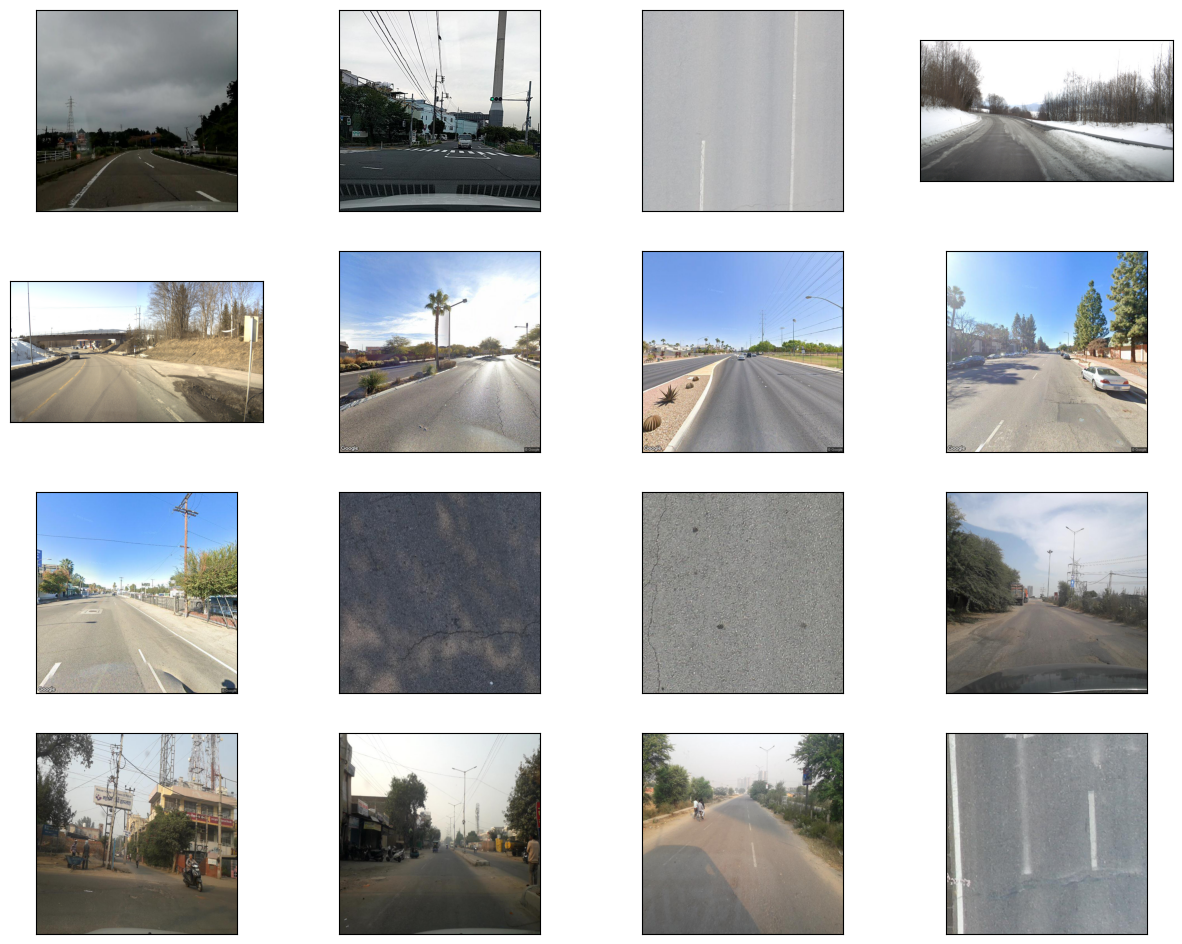

In [12]:
images = []
images_path = './data/corrupted/transfer/images'
for file in os.listdir(images_path)[:16]:
    images.append(plt.imread(os.path.join(images_path, file)))

scale = 4
fig, axes = plt.subplots(nrows=scale, ncols=scale, figsize=(15, 12),  #Размер вывода
                         subplot_kw={'xticks': [], 'yticks': []})
image_indx = 0
for i, ax in enumerate(axes):
    for count in range(scale):
        ax[count].imshow(images[image_indx])
        image_indx += 1

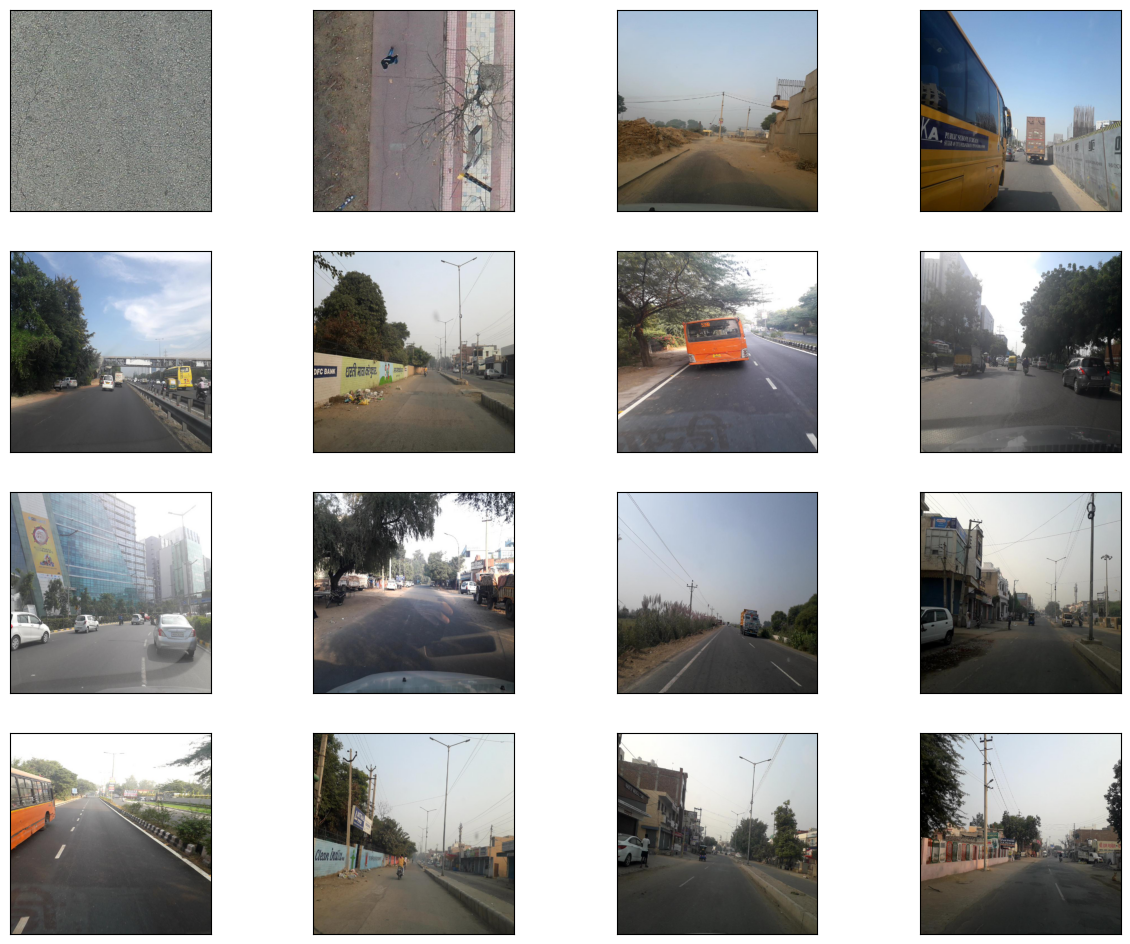

In [13]:
images = []
images_path = './data/corrupted/empty/images'
for file in os.listdir(images_path)[:16]:
    images.append(plt.imread(os.path.join(images_path, file)))

scale = 4
fig, axes = plt.subplots(nrows=scale, ncols=scale, figsize=(15, 12),  #Размер вывода
                         subplot_kw={'xticks': [], 'yticks': []})
image_indx = 0
for i, ax in enumerate(axes):
    for count in range(scale):
        ax[count].imshow(images[image_indx])
        image_indx += 1

Как можем увидеть, что в полностью пустых, что в данных с переносом строки присутствуют дефекты дорог. Поэтому все эти данные можем объединить в одну папку и переразметить их если нужно

In [14]:
path = './data/corrupted'
for dir in next(os.walk(path))[1]:
    shutil.copytree(os.path.join(path, dir), os.path.join(path),dirs_exist_ok=True)
    shutil.rmtree(os.path.join(path, dir))

Проверяем сумму всех этих файлов

In [15]:
print(len(os.listdir('./data/corrupted/annatations')))
len(os.listdir('./data/corrupted/images'))

1260


1260

Столько сколько и было

Размечаем данные с помощью Yolo-Annotation-Tool

In [16]:
!git clone https://github.com/pascalberski/YOLO-Annotation-Tool

fatal: destination path 'YOLO-Annotation-Tool' already exists and is not an empty directory.


### Запуск через Annotate.html

In [17]:
%cd YOLO-Annotation-Tool
!Annotate.html
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj\YOLO-Annotation-Tool
D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj


- Пустые данные 
- Объединение разметки в 1 json

# Анализ данных

Нам предоставлена директория new с папками 1, 2 и текстовым документом labels.txt обозначающим классы повреждений дороги: D00, D10, D20, D40, Block crack, Repair. В директориях 1 и 2 предоставлены страны в которых делались снимки для разметки дороги: India, Japan, China, Norway, United_States. В каждой из папок есть директории annatations и images содержащие разметку в txt файле с указанием класса и 4 параметров разметки и самих изображений дороги соответственно.

По заданию я объединил директории 1 и 2 с странами разметки в одну папку data с сохранением всех файлов. Также пройдясь по всем директориям стран я соединил все данные в папке all той же директории data для удобства и дальнейшего исследования без привязки к странам. Все файлы в all я переименовал в их очерёдность также для удобства и отвязки от класса страны. Все данные в annatations проверил на пропуски и сохранил такие файлы и их изображения в директории corrupted сначала по разному содержанию аномальных данных, а потом объединил их т.к. утвердился с помощью визуализации в наличии не размеченных участков повреждённой дороги в обоих типах разметки без данных. Далее уже размеченные файлы где это нужно я перенёс в общую папку all добавив их в остальные данные и перезаписав пустые разметки более правильными.

Перед переразметкой изучил различные предоставленные классы по уже размеченным данным с помощью визуализации этих классов в коде.

In [ ]:
Типо визуализация классов трещин

Что над сделать:
- Просмотреть классы трещин вместе с боксами каким-то образом :? описать их ниже
- Разметить данные/выполнить то что вверху по пунктикам
- Создать документацию на обработанные данные по пунктам xlx: описание данных, какие классы существуют, и всё это отраслевым стандартом

Выяснилось что классы:
- D00 -
- D10 -
- D20 -
- D40 -
- Block crack -
- Repair -


# PyTorch Yolov5

In [2]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

  Obtaining dependency information for gitpython>=3.1.30 from https://files.pythonhosted.org/packages/45/c6/a637a7a11d4619957cb95ca195168759a4502991b1b91c13d3203ffc3748/GitPython-3.1.41-py3-none-any.whl.metadata
  Obtaining dependency information for ultralytics>=8.0.232 from https://files.pythonhosted.org/packages/57/e4/762a111cb112f751eda6fa6716a97c00eecaff09e7d2d3835d96e29fcd5d/ultralytics-8.1.9-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/40.2 kB ? eta -:--:--
     ---------------------------------------- 40.2/40.2 kB ? eta 0:00:00
  Obtaining dependency information for gitdb<5,>=4.0.1 from https://files.pythonhosted.org/packages/fd/5b/8f0c4a5bb9fd491c277c21eff7ccae71b47d43c4446c9d0c6cff2fe8c2c4/gitdb-4.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for smmap<6,>=3.0.1 from https://files.pythonhosted.org/packages/a7/a5/10f97f73544edcdef54409f1d839f6049a0d79df68adbc1ceb24d1aaca42/smmap-5.0.1-py3-none-any.whl.metadata
   -------------

In [9]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Image
im = 'https://ultralytics.com/images/zidane.jpg'

# Inference
results = model([im, im, im])

Using cache found in C:\Users\nicka/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-5 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [14]:
results.pandas().xyxy[2]

,xmin,ymin,xmax,ymax,confidence,class,name
0,742.988525,48.350983,1141.838379,720.000000,0.881153,0,person
1,442.009613,437.523804,496.660126,709.984619,0.675283,27,tie
2,123.009552,193.280334,715.688965,719.748596,0.664540,0,person
3,982.797668,308.415131,1027.356812,419.990875,0.260213,27,tie


# GitHub Yolov5

In [40]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
%cd ../

D:\Github proj\MachineLearning\ML\PROducts\CV\Detection_Animals\yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


D:\Github proj\MachineLearning\ML\PROducts\CV\Detection_Animals


In [42]:
!echo %cd%

D:\Github proj\MachineLearning\ML\PROducts\CV\Detection_Animals


# Yolo-Annotation-Tool

## Без предопределённых боксов

In [43]:
!git clone https://github.com/ManivannanMurugavel/Yolo-Annotation-Tool-New-

Cloning into 'Yolo-Annotation-Tool-New-'...


In [52]:
%cd Yolo-Annotation-Tool-New-
# create classes.txt file and write all classes what you train the objects2
# run main.py
# run process.py
%cd ../

D:\Github proj\MachineLearning\ML\PROducts\CV\Detection_Animals\Yolo-Annotation-Tool-New-
D:\Github proj\MachineLearning\ML\PROducts\CV\Detection_Animals


## С определёнными боксами, web

In [13]:
!git clone https://github.com/pascalberski/YOLO-Annotation-Tool

Cloning into 'YOLO-Annotation-Tool'...


### Запуск через Annotate.html

In [24]:
%cd YOLO-Annotation-Tool
!Annotate.html
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj\YOLO-Annotation-Tool
D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj


In [50]:
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj
